# Cahn-Hilliard with Primitive and Legendre Bases

This example uses a Cahn-Hilliard model to compare two different bases representations to discretize the microstructure. One basis representation uses the primitive (or hat) basis and the other uses Legendre polynomials. The example includes the background theory about using Legendre polynomials as a basis in MKS. The MKS with two different bases are compared with the standard spectral solution for the Cahn-Hilliard solution at both the calibration domain size and a scaled domain size. 

### Cahn-Hilliard Equation

The Cahn-Hilliard equation is used to simulate microstructure evolution during spinodial decomposition and has the following form,

$$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

where $\phi$ is a conserved ordered parameter and $\sqrt{\gamma}$ represents the width of the interface. In this example, the Cahn-Hilliard equation is solved using a semi-implicit spectral scheme with periodic boundary conditions, see  [Chang and Rutenberg](http://dx.doi.org/10.1103/PhysRevE.72.055701) for more details.

### Basis Functions for the Microstructure Function and Influence Function

In this example, we will explore the differences when using the
Legendre polynomials as the basis function compared to the primitive
(or hat) basis for the microstructure function and the influence coefficients.

For more information about both of these basis please see the [theory section](THEORY.html).

In [1]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from pymks.fmks.data.cahn_hilliard import generate
from toolz.curried import curry, pipe
from toolz.curried import map as fmap
from dask_ml.model_selection import train_test_split, GridSearchCV
from pymks.fmks.localization import LocalizationRegressor, flatten, ReshapeTransformer, coeff_to_real
from sklearn.pipeline import Pipeline
from pymks.fmks.bases.legendre import LegendreTransformer
from pymks.fmks.bases.primitive import PrimitiveTransformer
from distributed import Client
import dask.array as da
from pymks.fmks.func import iterate_times
from sklearn import metrics


Client()

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/__init__.py:465: UserWarning: matplotlibrc text.usetex option can not be used unless TeX is installed on your system
  warnings.warn('matplotlibrc text.usetex option can not be used unless '
/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/__init__.py:473: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.6 or later is installed on your system
  'your system' % dvipng_req)
/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/__init__.py:480: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-8.60 or later is installed on your system
  % gs_req)


<Client: scheduler="127.0.0.1:8786" processes=12 cores=12>

## Modeling with MKS

### Generating Calibration Datasets

Because the microstructure is a continuous field that can have a range of values and changes over time, the first order influence coefficients cannot be calibrated with delta microstructures. Instead, a large number of simulations with random initial conditions will be used to calibrate the first order influence coefficients using linear regression. Let's show how this is done.

The function `generate` from `pymks.fmks.data.cahn_hilliard` provides a nice interface to generate calibration datasets for the influence coefficients. The function `generate` requires the number of calibration samples, given by the first element of `shape`, and the shape of the domain, given by the following elements of `shape`.

In [2]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
da.random.seed(99)

X, y = generate(shape=(100, 41, 41), chunks=(40, 41, 41), delta_t=1e-2)

The function `generate` has generated `n_samples` number of random microstructures, `X`, and returned the same microstructures after they have evolved for one time step, given by `y`. Let's take a look at one of them.

In [3]:
@curry
def plot_ax(ax, arrs, titles):
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(titles[ax.colNum])
    return ax.imshow(
        arrs[ax.colNum],
        interpolation='none',
        vmin=np.min(np.vstack(arrs)),
        vmax=np.max(np.vstack(arrs))
    )


def colorbar(fig, ax, im):
    ax.yaxis.set_offset_position('right')
    fig.colorbar(im, cax=ax)


def plot(*arrs, titles):
    fig, axs = plt.subplots(1, len(arrs), figsize=(4 * len(arrs), 4))
    fig.subplots_adjust(right=0.8)
    if len(arrs) == 1:
        axs_ = [axs]
    else:
        axs_ = axs
    colorbar(
        fig,
        fig.add_axes([1.0, 0.05, 0.05, 0.9]),
        list(fmap(plot_ax(arrs=arrs, titles=titles), axs_))[0]
    )
    plt.tight_layout()

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


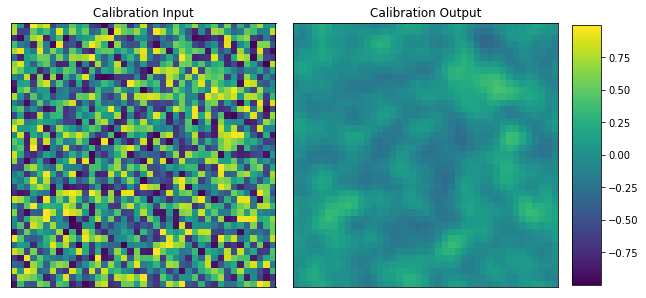

In [4]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

plot(X[0], y[0], titles=('Calibration Input', 'Calibration Output'))

### Calibrate Influence Coefficients
 
In this example, we compare the difference between using the primitive (or hat) basis and the Legendre polynomial basis to represent the microstructure function. As mentioned above, the microstructures (concentration fields) are not discrete phases. This leaves the number of local states in local state space as a free hyperparameter. In the next section, we look to see what a practical number of local states for bases would be. 
 
### Optimizing the Number of Local States
 
Below, we compare the difference in performance, as we vary the local state, when we choose the primitive basis and the Legendre polynomial basis.

The `(X, y)` sample data is split into training and test data. The code then optimizes `n_states` between `2` and `11` and the two `basis` with the `parameters_to_tune` variable. The `GridSearchCV` takes an `MKSLocalizationModel` instance, a `scoring` function (figure of merit) and the `parameters_to_tune` and then finds the optimal parameters with a grid search.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(flatten(X), flatten(y), test_size=0.2, random_state=3)

model = Pipeline(steps=[
    ('reshape', ReshapeTransformer(shape=X.shape)),
    ('discretize', PrimitiveTransformer(n_state=2, min_=-1.0, max_=1.0)),
    ('regressor', LocalizationRegressor())
])    

n_states = range(2, 11)
params = dict(
    discretize__n_state=n_states,
    discretize=[PrimitiveTransformer(n_state=2, min_=-1.0, max_=1.0),
                LegendreTransformer(n_state=2, min_=-1.0, max_=1.0)]
)

gs = GridSearchCV(model, params, cv=5, n_jobs=-1)

_ = gs.fit(X_train, y_train)

The optimal parameters are the `LegendreBasis` with only 4 local states. More terms don't improve the R-squared value.

In [6]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print(gs.best_estimator_)
print(gs.score(X_test, y_test))

Pipeline(memory=None,
     steps=[('reshape', ReshapeTransformer(shape=(100, 41, 41))), ('discretize', LegendreTransformer(chunks=None, max_=1.0, min_=-1.0, n_state=4)), ('regressor', LocalizationRegressor(redundancy_func=<function <lambda> at 0x7f9df40d0d90>))])
1.0


In [7]:
gs.cv_results_['mean_test_score']

array([0.99949218, 0.99948355, 0.99991144, 0.99997276, 0.99998913,
       0.99999482, 0.99999719, 0.99999834, 0.99999894, 0.99949218,
       0.99948349, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

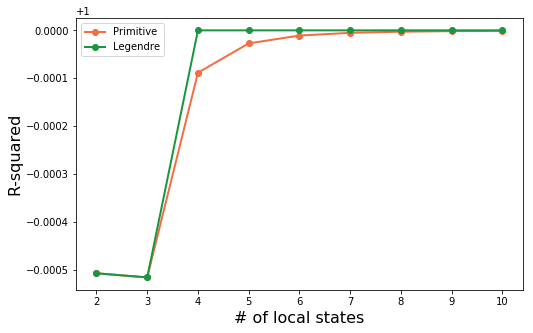

In [8]:
fig, _ = plt.subplots(1, 1, figsize=(8, 5))
plt.plot(n_states, gs.cv_results_['mean_test_score'][:9], 'o-', color='#f46d43', linewidth=2, label='Primitive')
plt.plot(n_states, gs.cv_results_['mean_test_score'][9:], 'o-', color='#1a9641', linewidth=2, label='Legendre')
plt.xlabel('# of local states', fontsize=16)
plt.ylabel('R-squared', fontsize=16)
plt.legend()
plt.show()

As you can see the `LegendreBasis` converges faster than the `PrimitiveBasis`. In order to further compare performance between the two models, lets select 4 local states for both bases.

### Comparing the Bases for `n_states=4`

In [9]:
def make_tuple(arr):
    return tuple(fmap(lambda x: arr[..., x], range(4)))

def make_model(klass):
    return Pipeline(steps=[
    ('discretize', klass(n_state=4, min_=-1.0, max_=1.0)),
    ('regressor', LocalizationRegressor())
])

def get_coeffs(klass):
    return pipe(
        make_model(klass).fit(X, y).steps[1][1].coeff,
        coeff_to_real,
        lambda x: x.real,
        make_tuple
    )

Now let's look at the influence coefficients for both bases.

First, the `PrimitiveBasis` influence coefficients:

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


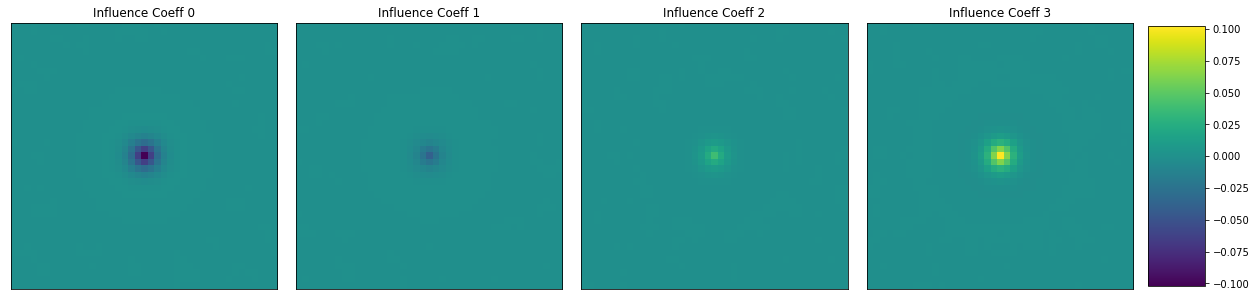

In [10]:
plot(*get_coeffs(PrimitiveTransformer),
     titles=list(fmap(lambda x: 'Influence Coeff {0}'.format(x), range(4))))


Now, the `LegendreBasis` influence coefficients:

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


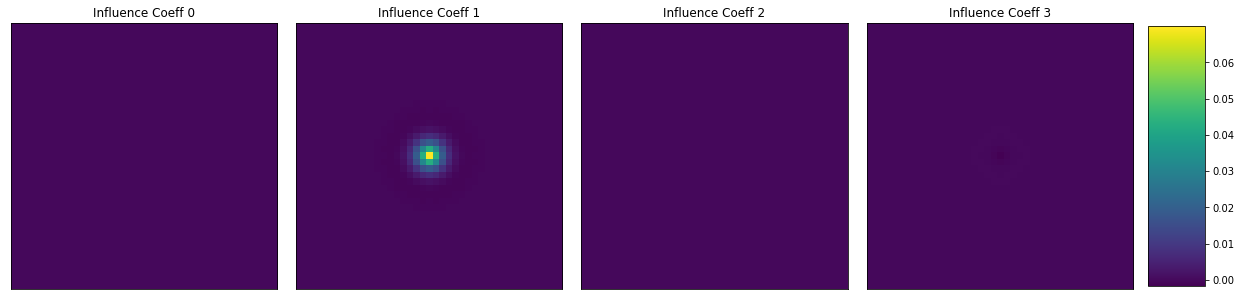

In [11]:
plot(*get_coeffs(LegendreTransformer),
     titles=list(fmap(lambda x: 'Influence Coeff {0}'.format(x), range(4))))

Now, let's do some simulations with both sets of coefficients and compare the results.

### Predict Microstructure Evolution

In order to compare the difference between the two bases, we need to have the Cahn-Hilliard simulation and the two MKS models start with the same initial concentration and evolve in time.

In [67]:
da.random.seed(66)
n_steps = 5
X5, y5 = generate(shape=(100, 41, 41), chunks=(10, 41, 41), delta_t=1e-2, n_steps=n_steps)
phi_ini, phi_test = generate(shape=(1, 41, 41), chunks=(1, 41, 41), delta_t=1e-2, n_steps=n_steps)

Let's look at the inital concentration field.

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


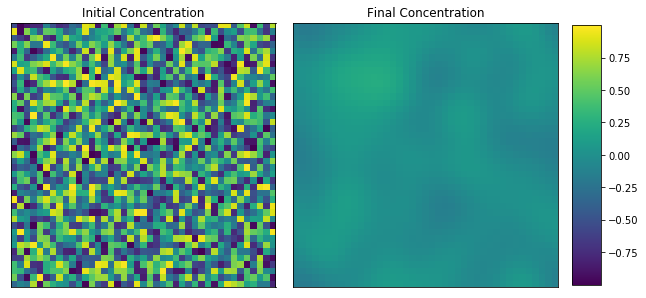

In [68]:
plot(phi_ini[0], phi_test[0], titles=['Initial Concentration', 'Final Concentration'])


In order to move forward in time, we need to feed the concentration back into the Cahn-Hilliard simulation and the MKS models.

In [69]:
model_legendre = make_model(LegendreTransformer).fit(X5, y5)
model_primitive = make_model(PrimitiveTransformer).fit(X5, y5)

In [70]:
phi_legendre = model_legendre.predict(phi_ini).compute()
phi_primitive = model_primitive.predict(phi_ini).compute()

Let's take a look at the concentration fields.

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


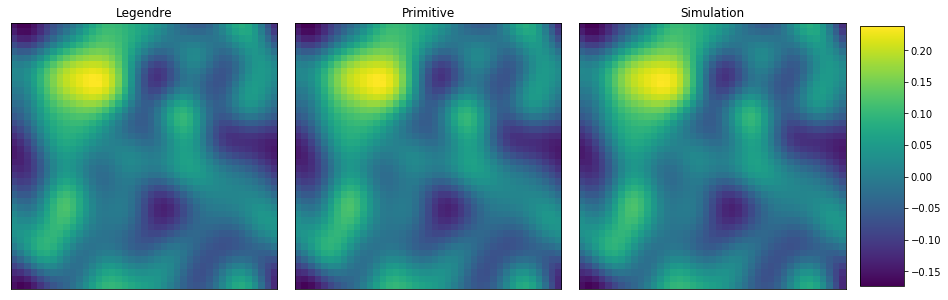

In [71]:
plot(phi_legendre[0], phi_primitive[0], phi_test[0], titles=('Legendre', 'Primitive', 'Simulation'))

By just looking at the three microstructures is it difficult to see any differences. Below, we plot the difference between the two MKS models and the simulation.

Primative mse = 5.708747766144557e-08
Legendre mse = 1.4491095818264429e-08


/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


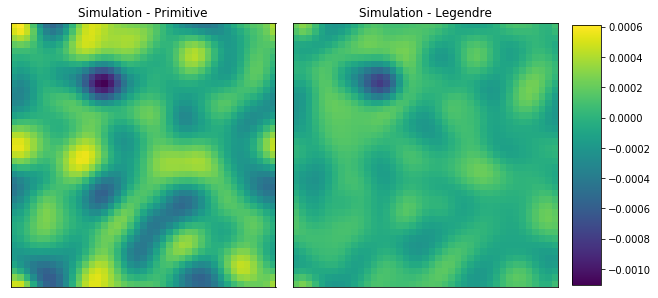

In [72]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

mse = metrics.mean_squared_error
plot(phi_test[0] - phi_primitive[0], phi_test[0] - phi_legendre[0],
     titles=['Simulation - Primitive', 'Simulation - Legendre'])

print('Primative mse =', mse(phi_test[0], phi_primitive[0]))
print('Legendre mse =', mse(phi_test[0], phi_legendre[0]))


The `LegendreBasis` basis clearly outperforms the `PrimitiveBasis` for the same value of `n_states`.

## Resizing the Coefficients to use on Larger Systems 

Below we compare the bases after the coefficients are resized.

In [80]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

shape = (1, X5[0].shape[1] * 3, X5[0].shape[1] * 3)
x_large, y_large = generate(shape=shape, chunks=shape, delta_t=1e-2, n_steps=n_steps)
model_primitive.steps[1][1].coeff_resize(shape[1:])
model_legendre.steps[1][1].coeff_resize(shape[1:])

LocalizationRegressor(redundancy_func=<function LocalizationRegressor.<lambda> at 0x7f9dfb84a268>)

Let's take a look at the initial large concentration field.

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


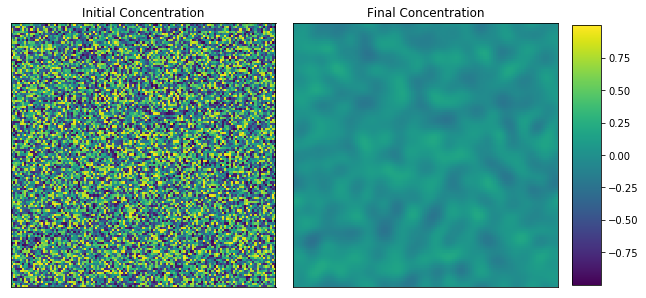

In [81]:
plot(x_large[0], y_large[0], titles=['Initial Concentration', 'Final Concentration'])

Let's look at the resized coefficients.

First, the influence coefficients from the `PrimitiveBasis`.

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


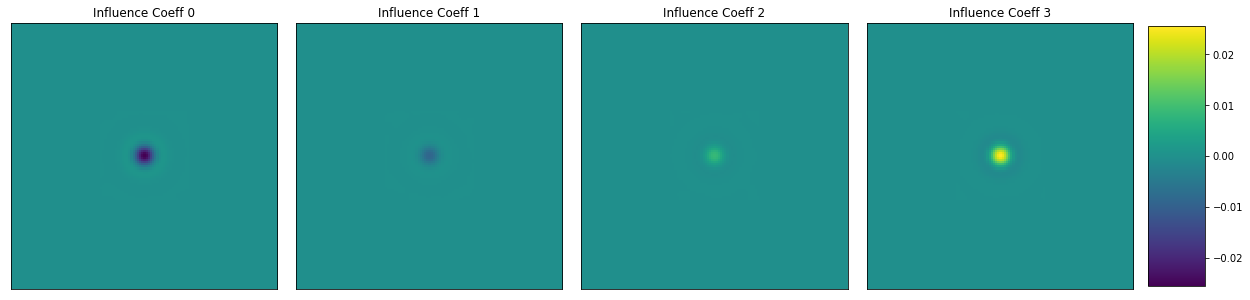

In [82]:
def get_coeffs(model):
    return pipe(
        model.steps[1][1].coeff,
        coeff_to_real,
        lambda x: x.real,
        make_tuple
    )

plot(*get_coeffs(model_primitive),
     titles=list(fmap(lambda x: 'Influence Coeff {0}'.format(x), range(4))))

Now, the influence coefficients from the `LegendreBases`.

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


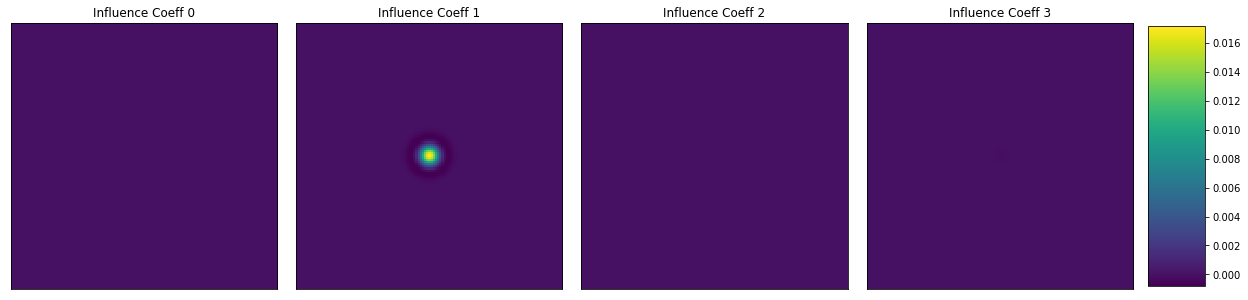

In [83]:
plot(*get_coeffs(model_legendre),
     titles=list(fmap(lambda x: 'Influence Coeff {0}'.format(x), range(4))))

Once again, we are going to predict the final results using the two models.

In [84]:
phi_legendre_large = model_legendre.predict(x_large).compute()
phi_primitive_large = model_primitive.predict(x_large).compute()

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


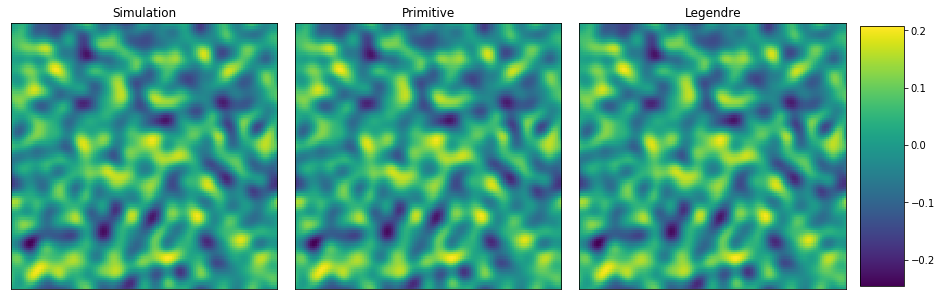

In [85]:
plot(y_large[0],
     phi_primitive_large[0],
     phi_legendre_large[0],
     titles=('Simulation', 'Primitive', 'Legendre'))


Both MKS models seem to predict the concentration faily well. However, the Legendre polynomial basis looks to be better. Again, let's look at the difference between the simulation and the MKS models.

/nix/store/b6pcn34yqrnnah35661qsv3x87ichad2-python3.6-matplotlib-2.1.2/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Primative mse = 6.768782591382963e-08
Legendre mse = 1.8633071572484037e-08


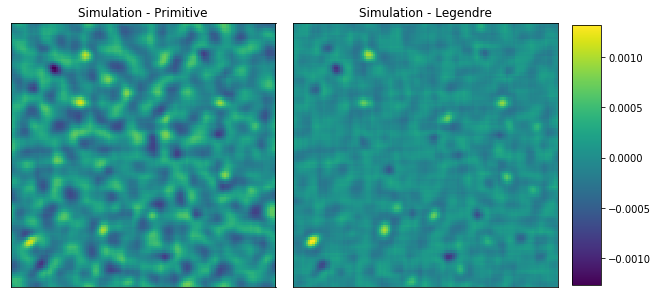

In [86]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

plot(y_large[0] - phi_primitive_large[0],
     y_large[0] - phi_legendre_large[0], 
    titles=['Simulation - Primitive','Simulation - Legendre'])

print('Primative mse =', mse(y_large[0], phi_primitive_large[0]))
print('Legendre mse =', mse(y_large[0], phi_legendre_large[0]))


With the resized influence coefficients, the `LegendreBasis` outperforms the `PrimitiveBasis` for the same value of `n_states`. The value of `n_states` does not necessarily guarantee a fair comparison between the two basis in terms of floating point calculations and memory used.